# 综合实战作业 1



在本次作业中，我们将使用 NumPy 和 PyTorch 计算第一讲中生成的字符图像间的相似度并进行排序，输出不同相似度的图像对。你只需要在 `# >>> TODO` 和 `# <<< TODO` 间填写代码。

## 数据读取

首先，让我们定义加载数据集的函数。步骤如下：

- 先使用 `pathlib.Path.glob` 找出所有扩展名为 `.jpg` 的文件。如果你不习惯使用 `pathlib` 库，可以用 `os` 和 `glob` 库替代。
- 再使用 `cv2.imread` 读取图像并用 `cv2.cvtColor` 转换为灰度格式，并用 `pathlib.Path.stem` 提取文件名。
- 通过列表生成式生成所有的数据条目 `data`。

`data` 中每条数据的格式为 `(img_name: str, img: numpy.ndarray)`。

In [107]:
import cv2
from pathlib import Path

def load_dataset(data_root):
    # >>> TODO
    images = Path(data_root).glob('*.jpg')
    data = [(file.stem, cv2.cvtColor(cv2.imread(str(file)), cv2.COLOR_BGR2GRAY))
            for file in images]
    # <<< TODO
    return data

让我们读取数据集，并使用 `matplotlib` 打印图像看看它长什么样子。

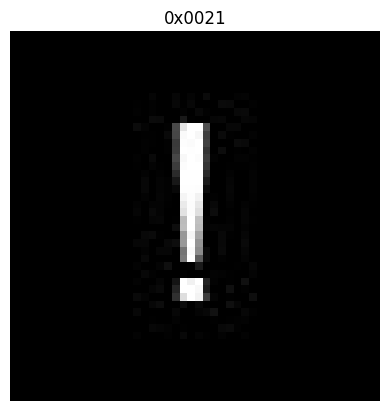

In [108]:
import matplotlib.pyplot as plt

data = load_dataset('./data')

def imshow(img, title=None):
    plt.figure()
    plt.imshow(img, cmap='gray')
    if title is not None: plt.title(title)
    plt.axis('off')

img_name, img = data[0]
imshow(img, img_name)

我们检测重复和相似图像的原理是计算图像向量间的余弦相似度。对于图像 $\mathbf X_1, \mathbf X_2 \in M_{H,W,C} (\mathbb R)$，我们首先将其展平为列向量 $\boldsymbol y_1, \boldsymbol y_2 \in \mathbb R^{HWC}$，然后计算两个向量的余弦相似度：
$$
S_{C}(\boldsymbol y_1, \boldsymbol y_2):=\frac{\boldsymbol y_1 \cdot \boldsymbol y_2}{\|\boldsymbol y_1 \|\|\boldsymbol y_2 \|}
$$
相似度越接近 1，说明两幅图像越相似。在计算相似度时，建议先将像素取值转换为浮点数并归一化，防止溢出和数据类型带来的问题。

下面我们将按照这个思路，分别采用 NumPy 和 PyTorch 实现计算图像相似度的算法（PyTorch 部分内容可在第三讲培训之后完成），并对比不同实现的速度。特别地，对于 NumPy， 我们先尝试简单的多重 for 循环的实现，再尝试采用矩阵计算的实现。

## 使用 NumPy 和两重循环

下面请你用两重循环，计算图片间的两两相似度，并将相似度取值和对应的图像对序号保存到列表中。注意不要包括“图像自己和自己组成的图像对”以及“可交换顺序的图像组成的图像对”。

In [109]:
import numpy as np

similarity_list = []
pair_list = []
# >>> TODO
for i in range(len(data)-1):
    for j in range(i+1, len(data)):
        pair_list.append((data[i][0], data[j][0]))
        similarity_list.append(np.dot(data[i][1].flatten(), data[j][1].flatten()) / 
                               (np.linalg.norm(data[i][1].flatten()) * np.linalg.norm(data[j][1].flatten())))
# <<< TODO

挺慢是吧！下一节直接用矩阵计算时，你就能非常直观地感受运算速度的差别。

下面请你按照从大到小的顺序对相似度进行排序，保存排序后的索引列表。

In [110]:
# >>> TODO
# indexes = ?
indexes = np.argsort(similarity_list)[::-1]
# <<< TODO

## 使用 NumPy 和矩阵运算

其实，我们可以使用矩阵运算一次性计算所有图像的两两相似度，这可以大大加快计算速度。计算公式如下：
$$
\mathbf Y = \begin{pmatrix}
\boldsymbol y_1^\intercal \\
\boldsymbol y_2^\intercal \\
\vdots \\
\boldsymbol y_n^\intercal
\end{pmatrix}
\\
\mathbf W = \mathbf Y \mathbf Y^\intercal \\
\mathbf N = (\|\boldsymbol y_1 \|, \|\boldsymbol y_2 \|, \dots, \|\boldsymbol y_n \|)^\intercal(\|\boldsymbol y_1 \|, \|\boldsymbol y_2 \|, \dots, \|\boldsymbol y_n \|) \\
\mathbf S = \mathbf W \oslash \mathbf N
$$

其中 $\oslash$ 表示逐元素除法。则图像 $\mathbf X_i, \mathbf X_j$ 的相似度为 $\mathbf S$ 的元素 $s_{i,j}$。

下面请你根据以上计算公式，完成矩阵版本的 NumPy 计算代码。

In [111]:
# >>> TODO
Y = np.array([np.ravel(data[i][1])
             for i in range(len(data))], dtype=np.float64)
W = np.dot(Y, Y.T)
N = np.dot(np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64),
           np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64).T)
S = W / N
# <<< TODO

因为每幅图像与自身的相似度一定为 1，且矩阵 $\mathbf S$ 为对称矩阵，所以实际有效的部分为 $\mathbf S$ 的减去主对角线的上三角矩阵。然后，我们对相似度按从大到小的方向进行排序，即可找出相同或相似的图像对。请你完成如下排序代码，要求最终得到元素为 `(行号，列号)` 的索引列表。

In [112]:
S = np.triu(S, k=1)  # S 的减去主对角线的上三角矩阵
# >>> TODO
# 对 S 的元素按照从大到小进行排序，得到元素的索引。
Ssort = np.argsort(S, axis=None)[::-1]
indexes = np.array([(Ssort[i] // len(data), Ssort[i] % len(data))
                    for i in range(int(len(data)*(len(data)-1)/2))])
# <<< TODO

下面我们借助 matplotlib 来看一看不同相似度的图像（还没学过 matplotlib 没关系，相关的代码已为你写好）。请你定义一个 `plot_results(data, S, indexes)` 函数，接受图像数据 `data`、相似度矩阵 `S` 和排序后的索引 `indexes` 为输入，以 2x2 subplot 的方式，画出相似度排名最高、第 0.1%、第 1% 和第 10% 的图像对。要求在每个 subplot 中，先将图像对的两幅图像沿宽度拼接，然后再进行绘制，并使用相似度作为图像的标题。

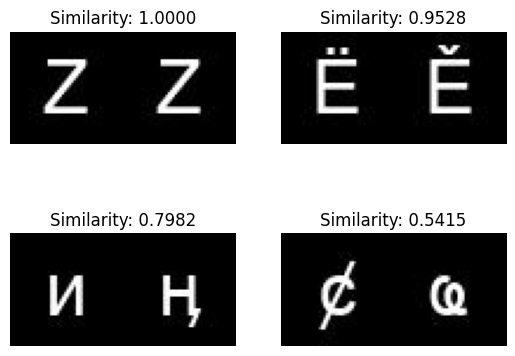

In [113]:
def plot_results(data, S, indexes):
    plot_indexes = [0, int((len(indexes) - 1) * 1e-3),
                    int((len(indexes) - 1) * 1e-2), int((len(indexes) - 1) * 1e-1)]
    fig, axs = plt.subplots(2, 2)
    for r in range(2):
        for c in range(2):
            # >>> TODO
            img = np.concatenate([data[indexes[plot_indexes[r*2+c]][0]]
                                 [1], data[indexes[plot_indexes[r*2+c]][1]][1]], axis=1)
            similarity = S[indexes[plot_indexes[r*2+c]]
                           [0]][indexes[plot_indexes[r*2+c]][1]]
            # <<< TODO
            axs[r, c].imshow(img, cmap='gray')
            axs[r, c].set_title(f'Similarity: {similarity:.4f}')
            axs[r, c].axis('off')

plot_results(data, S, indexes)

## 使用 PyTorch 和矩阵运算

请仿照上一节，使用 PyTorch + 矩阵运算解决该问题。首先请你计算图像的相似度矩阵 `S`：

In [114]:
import torch

# 根据 CUDA 是否可用确定使用的设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# >>> TODO
# 请注意将 Tensor 存放在 `device` 定义的设备上。
Y = torch.tensor([np.ravel(data[i][1])
                 for i in range(len(data))], dtype=torch.float64, device=device)
W = torch.matmul(Y, Y.transpose(0, 1))
N = torch.from_numpy(np.dot(np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64),
                            np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64).T))
S = W / N
# <<< TODO

请你仿照上一节，对相似度矩阵 S 的元素进行排序，并得到元素为 `(行号，列号)` 的索引列表：

In [115]:
S = torch.triu(S, diagonal=1)  # S 的减去主对角线的上三角矩阵

# >>> TODO
# 对 S 的元素按照从大到小进行排序，得到元素的索引。
Ssort = torch.argsort(torch.flatten(S), descending=True)
indexes = torch.tensor([(Ssort[i] // len(data), Ssort[i] % len(data))
                        for i in range(int(len(data)*(len(data)-1)/2))], device=device)
# <<< TODO

让我们看看 PyTorch 的结果吧！

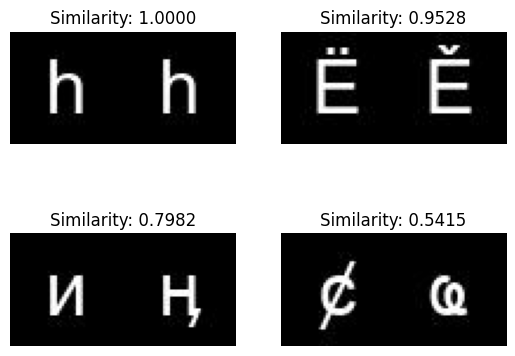

In [116]:
plot_results(data, S, indexes)

## NumPy 和 PyTorch 速度测试

最后，让我们对比一下三种方式的执行速度。这里我们会创建一个可以统计函数运行时间的 [装饰器](https://www.liaoxuefeng.com/wiki/1016959663602400/1017451662295584)，感兴趣的同学可以点击链接了解其原理。

In [117]:
from functools import wraps
from time import perf_counter

def timer(func):
    # This function shows the execution time of the function object passed
    @wraps(func)
    def wrap_func(*args, **kwargs):
        args_str = ', '.join([f'{v!r}' for v in args])
        kwargs_str = ', '.join([f'{k}={v!r}' for k, v in kwargs.items()])
        comma_str = ', ' if (args_str != '' and kwargs_str != '') else ''
        t_start = perf_counter()
        result = func(*args, **kwargs)
        t_end = perf_counter()
        print(f'Function {func.__name__}({args_str}{comma_str}{kwargs_str}) executed in {(t_end - t_start):.4f}s')
        return result

    return wrap_func

接下来我们分别定义三种方式的测试函数（你需要把前面的代码复制粘贴过来）。

In [118]:
@timer
def test_numpy_for_loop():
    @timer
    def load_and_calc():
        similarity_list = []
        pair_list = []
        # >>> TODO
        for i in range(len(data)-1):
            for j in range(i+1, len(data)):
                pair_list.append((data[i][0], data[j][0]))
                similarity_list.append(np.dot(data[i][1].flatten(), data[j][1].flatten()) / 
                                    (np.linalg.norm(data[i][1].flatten()) * np.linalg.norm(data[j][1].flatten())))
        # <<< TODO
        return similarity_list, pair_list
    similarity_list, pair_list = load_and_calc()

    @timer
    def sort():
        # >>> TODO
        indexes = np.argsort(similarity_list)[::-1]
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes


@timer
def test_numpy():
    @timer
    def load():
        # >>> TODO
        Y = np.array([np.ravel(data[i][1])
                      for i in range(len(data))], dtype=np.float64)
        # <<< TODO
        return Y
    Y = load()

    @timer
    def calc():
        # >>> TODO
        W = np.dot(Y, Y.T)
        N = np.dot(np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64),
                np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64).T)
        S = W / N
        # <<< TODO
        S = np.triu(S, k=1)
        return S
    S = calc()

    @timer
    def sort():
        # >>> TODO
        Ssort = np.argsort(S, axis=None)[::-1]
        indexes = np.array([(Ssort[i] // len(data), Ssort[i] % len(data))
                            for i in range(int(len(data)*(len(data)-1)/2))])
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes


@timer
def test_torch(device=device):
    @timer
    def load():
        # >>> TODO
        Y = torch.tensor([np.ravel(data[i][1])
                          for i in range(len(data))], dtype=torch.float64, device=device)
        # <<< TODO
        return Y
    Y = load()

    @timer
    def calc():
        # >>> TODO
        W = torch.matmul(Y, Y.transpose(0, 1))
        N = torch.from_numpy(np.dot(np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64),
                                    np.array([[np.linalg.norm(np.ravel(data[i][1]))] for i in range(len(data))], dtype=np.float64).T))
        S = W / N
        # <<< TODO
        S = torch.triu(S, diagonal=1)
        return S
    S = calc()

    @timer
    def sort():
        # >>> TODO
        Ssort = torch.argsort(torch.flatten(S), descending=True)
        indexes = torch.tensor([(Ssort[i] // len(data), Ssort[i] % len(data))
                                for i in range(int(len(data)*(len(data)-1)/2))], device=device)
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes

下面进行测试。

In [119]:
test_numpy_for_loop()
print('-' * 50)
test_numpy()
print('-' * 50)
test_torch()
if device == 'cuda':
    print('-' * 50)
    test_torch('cpu')

Function load_and_calc() executed in 8.5911s
Function sort() executed in 0.0815s
Function test_numpy_for_loop() executed in 8.6885s
--------------------------------------------------
Function load() executed in 0.0047s
Function calc() executed in 0.0343s
Function sort() executed in 0.4098s
Function test_numpy() executed in 0.4504s
--------------------------------------------------
Function load() executed in 0.2098s
Function calc() executed in 0.0415s
Function sort() executed in 9.5950s
Function test_torch() executed in 9.8468s


你有什么发现吗？请写在下面。